## Inverter Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy import sin, cos,pi,zeros,sqrt
import pandas as pd

In [2]:
def dq0_abc_transform(v_d,v_q,v_0,omega,t_sol):
  wt = omega*np.array(t_sol)
  one = np.ones(len(wt))
  a = cos(wt)*v_d - sin(wt)*v_q + one*v_0
  b = cos(wt-2*pi/3)*v_d -sin(wt-2*pi/3)*v_q + one*v_0
  c = cos(wt+2*pi/3)*v_d -sin(wt+2*pi/3)*v_q + one*v_0
  return np.array([a,b,c])

In [3]:
Vdc = 800;
Kpc,Kic = 50,5000;
Rf = 0.07;
Lf = 5.2e-3;
Cf = 100e-6;
Lc = 1.5e-4;
Rc = 0.05;
w = 2*pi*50;
Kppll = 180;
Kipll = 3200;

In [4]:
def Inverter_Controller1(t,x):
    delta,ePLL,aPLL,ild,ilq,vod,voq,iod,ioq,zetad,zetaq = x
    #grid model   
    vbD,vbQ = 400*np.sqrt(2/3),0
    #ref setpoint
    ifdref,ifqref = 50, 0
    wgrid = 2*pi*50
    vbd,vbq = -np.sin(delta)*vbD + np.cos(delta)*vbQ, -np.cos(delta)*vbD - np.sin(delta)*vbQ
    #PLL Model
    ePLL_dot = (0-voq)
    w1 = Kppll*(0-voq) + Kipll*ePLL
    aPLL_dot = w1
    delta_dot = w1 - wgrid
    #current Controller
    zetad_dot = ifdref - ild
    zetaq_dot = ifqref - ilq
    vfdref = Kpc*(ifdref - ild) + Kic*zetad + vod - w1*Lf*ilq
    vfqref = Kpc*(ifqref - ilq) + Kic*zetaq + voq + w1*Lf*ild
    #Inverter Model
    vid,viq = np.array([vfdref,vfqref])
    #Filter Model
    ild_dot = (-Rf/Lf)*ild + w1*ilq + (vid - vod)/Lf
    ilq_dot = -w1*ild + (-Rf/Lf)*ilq + (viq - voq)/Lf
    vod_dot = w1*voq + (ild - iod)/Cf
    voq_dot = -w1*vod + (ilq - ioq)/Cf
    #Coupling Line
    iod_dot = (-Rc/Lc)*iod + w1*ioq + (vod - vbd)/Lc
    ioq_dot = -w1*iod + (-Rc/Lc)*ioq + (voq - vbq)/Lc

    return np.array([delta_dot,ePLL_dot,aPLL_dot,ild_dot,ilq_dot,vod_dot,voq_dot,iod_dot,ioq_dot,zetad_dot,zetaq_dot])


In [5]:
t0 = 0.0
t = 0.1
dt = 5e-6
t_eval = np.arange(t0,t,dt)
x0 = zeros(11)

In [6]:
In_sol0 = solve_ivp(Inverter_Controller1,[t0,t],y0 = x0,t_eval=t_eval)
t = In_sol0.t

In [7]:
deltas,ePLLs,aPLLs,ilds,ilqs,vods,voqs,iods,ioqs,zetads,zetaqs=In_sol0.y
tsim,iod,ioq,vod,voq,theta = pd.read_csv('I_data.csv').values

(0.0, 0.02)

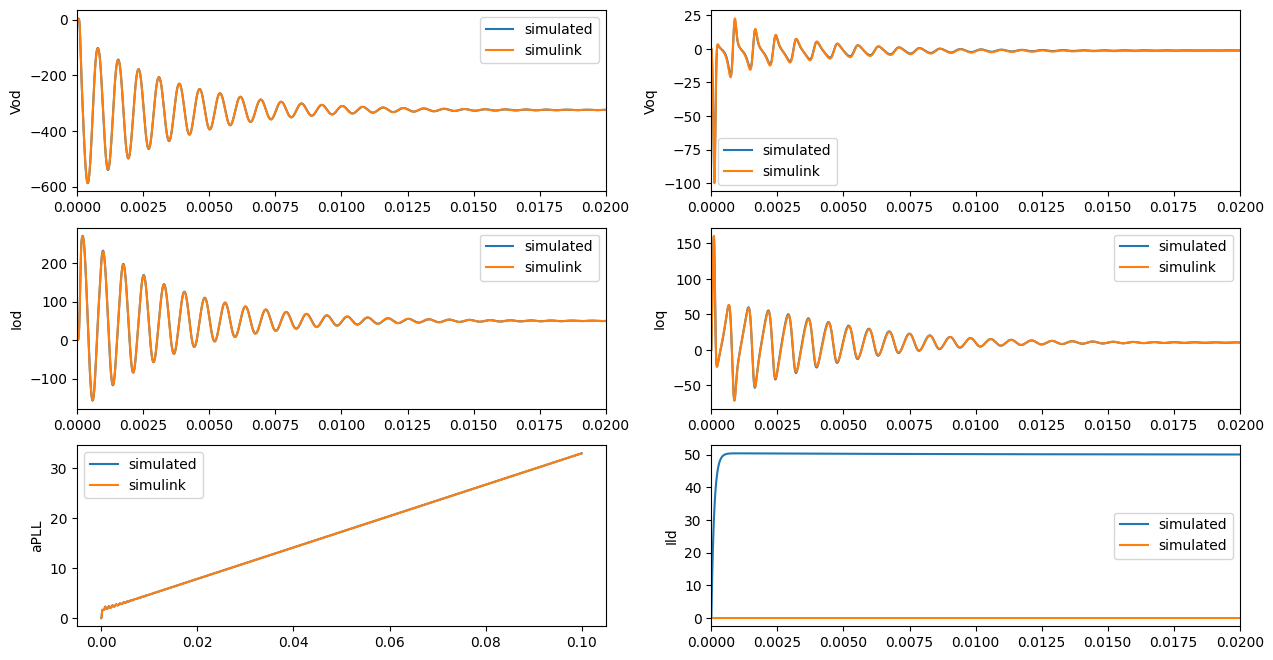

In [8]:
xlimit = [0,0.02]
fig, axs = plt.subplots(3, 2,figsize=(15,8))
axs[0, 0].plot(t_eval,vods,label = "simulated")
axs[0, 0].plot(tsim,vod,label="simulink")
axs[0, 0].set_xlim(xlimit)
axs[0, 0].set_ylabel("Vod")
axs[0, 0].legend()

axs[0, 1].plot(t_eval,voqs,label = "simulated")
axs[0, 1].plot(tsim,voq,label="simulink")
axs[0, 1].set_xlim(xlimit)
axs[0, 1].set_ylabel("Voq")
axs[0, 1].legend()

axs[1, 0].plot(t_eval,iods,label = "simulated")
axs[1, 0].plot(tsim,iod,label="simulink")
axs[1, 0].set_ylabel("Iod")
axs[1, 0].legend()
axs[1, 0].set_xlim(xlimit)

axs[1, 1].plot(t_eval,ioqs,label = "simulated")
axs[1, 1].plot(tsim,ioq,label="simulink")
axs[1, 1].set_ylabel("Ioq")
axs[1, 1].legend()
axs[1, 1].set_xlim(xlimit)

axs[2, 0].plot(t_eval, aPLLs,label = "simulated")
axs[2, 0].plot(tsim,theta,label="simulink")
axs[2, 0].set_ylabel("aPLL")
axs[2, 0].legend()
#axs[2, 0].set_xlim(xlimit)


axs[2, 1].plot(t_eval,ilds, label = "simulated")
axs[2, 1].plot(t_eval,ilqs, label = "simulated")
axs[2, 1].set_ylabel("Ild")
axs[2, 1].legend()
axs[2, 1].set_xlim(xlimit)

In [9]:
from sympy import symbols,Matrix,diff, sqrt,print_latex,zeros, sin,cos

def get_matrix(der,stat):
    mat = zeros(len(der),len(stat))
    for i in range(len(der)):
        for j in range(len(stat)):
            mat[i,j] = diff(der[i],stat[j])
    return mat

In [10]:
delta,ePLL,aPLL,zetad,zetaq,ild,ilq,vod,voq,iod,ioq,vbd,vbq = symbols(['delta','e_PLL','aPLL','zeta_d','zeta_q','i_ld','i_lq','v_od','v_oq','i_od','i_oq','v_bd','v_bq'])
idref,iqref,vbD,vbQ=symbols(['i_dref','i_qref','v_bD','v_bQ'])
Rf,Cf,Lf,Rc,Lc,w,winv = symbols(['R_f','C_f','L_f','R_c','L_c','omega','omega_inv'])
Kpc,Kic,Kipll,Kppll = symbols(['K_pc','K_ic','K_ipll','K_ppll'])

In [11]:
#ref setpoint
ifdref,ifqref = 50, 0
wgrid = 2*pi*50
#grid
vbd,vbq = -sin(delta)*vbD + cos(delta)*vbQ, cos(delta)*vbD - sin(delta)*vbQ
#PLL Model
ePLL_dot = (0-voq)
w1 = Kppll*(0-voq) + Kipll*ePLL
aPLL_dot = w1
delta_dot = w1 - wgrid
#current Controller
zetad_dot = ifdref - ild
zetaq_dot = ifqref - ilq
vfdref = Kpc*(ifdref - ild) + Kic*zetad + vod - w1*Lf*ilq
vfqref = Kpc*(ifqref - ilq) + Kic*zetaq + voq + w1*Lf*ild
#Inverter Model
vid,viq = np.array([vfdref,vfqref])
#Filter Model
ild_dot = (-Rf/Lf)*ild + w1*ilq + (vid - vod)/Lf
ilq_dot = -w1*ild + (-Rf/Lf)*ilq + (viq - voq)/Lf
vod_dot = w1*voq + (ild - iod)/Cf
voq_dot = -w1*vod + (ilq - ioq)/Cf
#Coupling Line
iod_dot = (-Rc/Lc)*iod + w1*ioq + (vod - vbd)/Lc
ioq_dot = -w1*iod + (-Rc/Lc)*ioq + (voq - vbq)/Lc


In [12]:
Xinv = Matrix([delta,ePLL,aPLL,zetad,zetaq,ild,ilq,vod,voq,iod,ioq])
Xinv_dot = Matrix([delta_dot,ePLL_dot,aPLL_dot,zetad_dot,zetaq_dot,ild_dot,ilq_dot,vod_dot,voq_dot,iod_dot,ioq_dot])
Winv = Matrix([vbD,vbQ])
Uinv = Matrix([idref,iqref])

Ainv,Binv,Dinv = get_matrix(Xinv_dot,Xinv),get_matrix(Xinv_dot,Uinv),get_matrix(Xinv_dot,Winv)

In [13]:
Kpci,Kici = 50,5000;
Rfi = 0.07;
Lfi = 5.2e-3;
Cfi = 100e-6;
Lci = 1.5e-4;
Rci = 0.05;
wi = 2*pi*50;
Kpplli = 180;
Kiplli = 3200;

deltasi,ePLLsi,aPLLsi,ildsi,ilqsi,vodsi,voqsi,iodsi,ioqsi,zetadsi,zetaqsi=In_sol0.y[:,1]

In [14]:
Amm = Ainv.subs([(Kppll,Kpplli),(Kipll,Kiplli),(Kic,Kici),(Kpc,Kpci),(Lf,Lfi),(Rf,Rfi),(Cf,Cfi),(Rc,Rci),(Lc,Lci),(w,wi)])
Amm = Amm.subs([(vbD,np.sqrt(2/3)*400),(vbQ,0),(delta,deltasi),(vod,vodsi),(voq,voqsi),(iod,iodsi),(ioq,ioqsi),(ePLL,ePLLsi)])
Bmm = Binv.subs([(Kpc,Kpci),(Lf,Lfi)])
Dmm = Dinv.subs([(delta,deltasi),(Lc,Lci)])
Am = np.array(Amm).astype(np.float64)
Bm = np.array(Bmm).astype(np.float64)
Dm = np.array(Dmm).astype(np.float64)



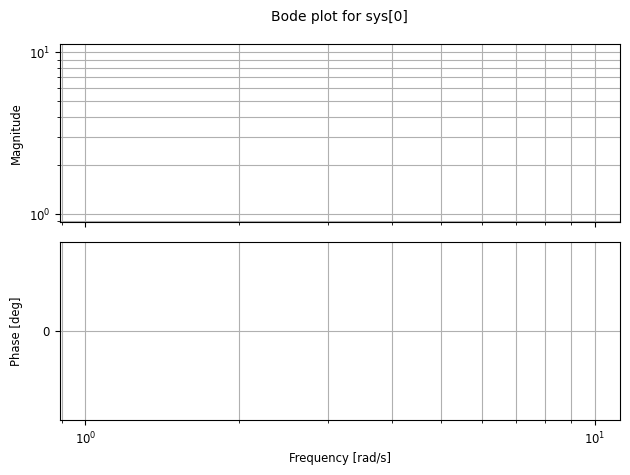

In [15]:
import control as cm

wrange = np.linspace(1,100000,1000)

A = Am
B = Dm[:,0]
C = np.zeros([Am.shape[0]])
D = np.array([0])
sys = cm.ss(A,B,C,D)
cm.bode(sys)

In [16]:
Xinv_dot

Matrix([
[                                                                                  K_ipll*e_PLL - K_ppll*v_oq - 314.159265358979],
[                                                                                                                          -v_oq],
[                                                                                                     K_ipll*e_PLL - K_ppll*v_oq],
[                                                                                                                      50 - i_ld],
[                                                                                                                          -i_lq],
[i_lq*(K_ipll*e_PLL - K_ppll*v_oq) - R_f*i_ld/L_f + (K_ic*zeta_d + K_pc*(50 - i_ld) - L_f*i_lq*(K_ipll*e_PLL - K_ppll*v_oq))/L_f],
[      i_ld*(-K_ipll*e_PLL + K_ppll*v_oq) - R_f*i_lq/L_f + (K_ic*zeta_q - K_pc*i_lq + L_f*i_ld*(K_ipll*e_PLL - K_ppll*v_oq))/L_f],
[                                                                         